In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# ================================
# 1️⃣ Load processed data
# ================================
processed_df = pd.read_csv("/content/drive/MyDrive/loan_data_processed.csv")

X = processed_df.drop(columns=['target']).values.astype('float32')
y = processed_df['target'].values.astype('int')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [2]:
# ================================
# 2️⃣ Build a strong NN model
# ================================
model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    LayerNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='AUC')]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
# ================================
# 3️⃣ Training settings
# ================================
es = EarlyStopping(
    monitor='val_AUC',
    patience=4,
    mode='max',
    restore_best_weights=True
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = dict(enumerate(cw))

In [4]:
# ================================
# 4️⃣ Train the model
# ================================
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=1024,
    callbacks=[es, lr_schedule],
    class_weight=cw,
    verbose=1
)



Epoch 1/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - AUC: 0.6755 - loss: 0.6559 - val_AUC: 0.7120 - val_loss: 0.6125 - learning_rate: 0.0010
Epoch 2/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - AUC: 0.7087 - loss: 0.6225 - val_AUC: 0.7150 - val_loss: 0.6213 - learning_rate: 0.0010
Epoch 3/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.7121 - loss: 0.6209
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
843/843 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - AUC: 0.7121 - loss: 0.6209 - val_AUC: 0.7168 - val_loss: 0.6185 - learning_rate: 0.0010
Epoch 4/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - AUC: 0.7145 - loss: 0.6191 - val_AUC: 0.7173 - val_loss: 0.6211 - learning_rate: 5.0000e-04
Epoch 5/30
842/843 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.7163 - loss: 0.6166
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
843/843 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - AUC: 0.7163 - loss: 0.6166 - val_AUC: 0.7178 - val_loss: 0.6246 - lear

8426/8426 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step

✅ Test AUC: 0.7187
✅ Test F1-Score: 0.4337


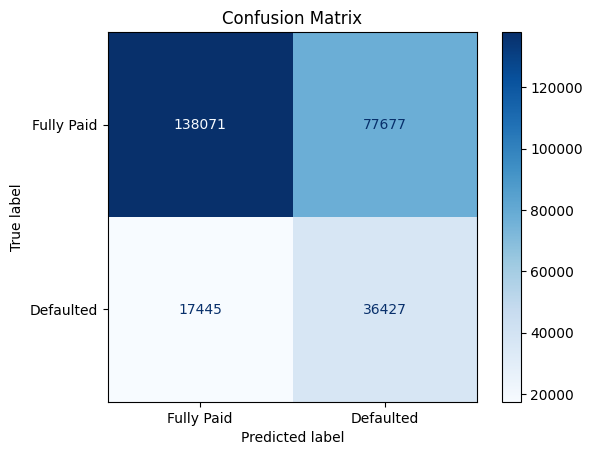

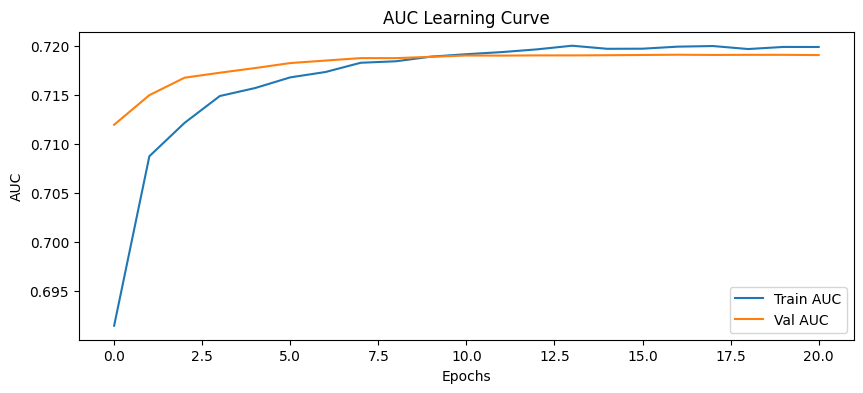

💾 Saved trained NN model to /content/drive/MyDrive/nn_best_model.h5


In [5]:
# ================================
# 5️⃣ Evaluate performance
# ================================
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred_labels)
print(f"\n✅ Test AUC: {auc:.4f}")
print(f"✅ Test F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
ConfusionMatrixDisplay(cm, display_labels=["Fully Paid", "Defaulted"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Learning curves
plt.figure(figsize=(10,4))
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Val AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title("AUC Learning Curve")
plt.show()

# Save trained model
model.save("/content/drive/MyDrive/nn_best_model.h5")
print("💾 Saved trained NN model to /content/drive/MyDrive/nn_best_model.h5")
